## Ajuste de la función de transferencia de un filtro RC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

**Creamos datos sintéticos**

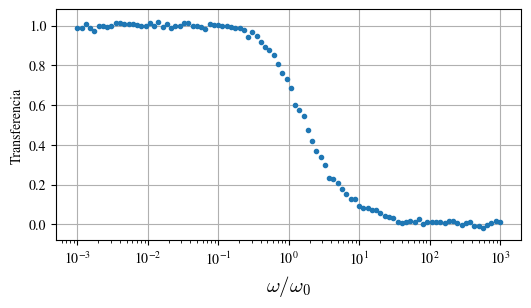

In [2]:
#creamos datos de un filtro rc pasa bajos

frecuencias = np.logspace(-1, 5, 100)

f0 = 100 #frecuencia de corte en Hz

transfe = 1 / np.sqrt( 1 + (frecuencias/f0)**2 ) + np.random.normal(loc=0, scale=0.01, size=len(frecuencias))

plt.figure(figsize=(6, 3))
plt.errorbar(frecuencias/f0, transfe, yerr=0.01, marker='.', linestyle='')
plt.xscale('log')
plt.grid(True)
plt.ylabel("Transferencia")
plt.xlabel(r"$\omega / \omega_{0}$", fontsize=15)
plt.show()

**Hacemos un ajuste**

In [3]:
#Hacemos un ajuste
def f(x, a, fc):
    return a / np.sqrt( 1 + (x/fc)**2 )

init_guess = [1, 10] # esto es importantísimo para ajustes no lineales!
popt, pcov = curve_fit(f, frecuencias, transfe, sigma=0.1*np.ones(len(frecuencias)), absolute_sigma=True) # popt son los parámetros del ajuste, pcov la "matriz de covarianza"
perr = np.sqrt(np.diag(pcov)) # los errores de los parámetros del ajuste son la raíz cuadrada de la diagonal de la matriz de covarianza

print('Resultados del ajuste:')
for i in range(len(popt)):
  print('Parámetro ' + str(i) + ': ' + str(popt[i]) + " \u00B1 " + str(perr[i]))
     

Resultados del ajuste:
Parámetro 0: 1.001040851963717 ± 0.01528997240376943
Parámetro 1: 99.17420088452356 ± 7.99782330826543


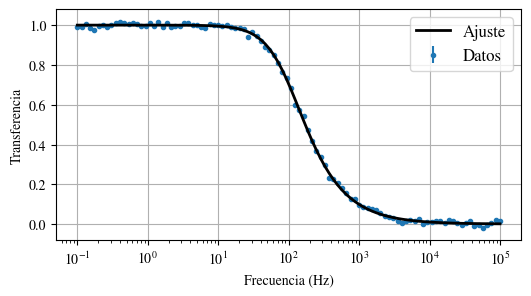

In [4]:
#Lo graficamos

plt.figure(figsize=(6, 3))
plt.errorbar(frecuencias, transfe, yerr=0.01, marker='.', linestyle='', label="Datos")
plt.plot(frecuencias, f(frecuencias, *popt),color='k', label="Ajuste", lw=2, zorder=10) 
plt.xscale('log')
plt.grid(True)
plt.legend(loc=1, fontsize=12)
plt.ylabel("Transferencia")
plt.xlabel("Frecuencia (Hz)")
plt.show()

## Bondad del ajuste

## Crédito: Pablo Cobelli (DF-UBA)

Acá el github de Pablo para Labo 1: [link](https://github.com/pablocobelli/laboratorio1/tree/main)

**Residuos y chi cuadrado**

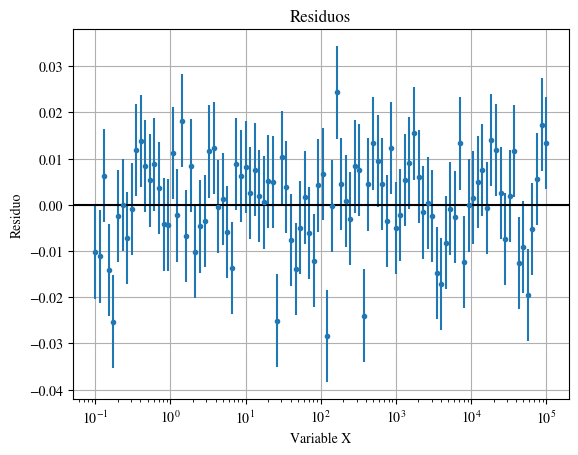

In [5]:
# los calculamos
y = transfe #variable y
x = frecuencias #variable x
yerr = 0.01 * np.ones_like(x) #error en y
y_modelo = f(frecuencias, *popt) #ajuste

#calculamos los residuos
residuo = y - y_modelo

# los grafico:
plt.figure()
plt.title('Residuos')
plt.xlabel('Variable X')
plt.ylabel('Residuo')
plt.errorbar(x, residuo, yerr=yerr, marker='.', linestyle='')
plt.xscale('log')
plt.axhline(0, color='k')
plt.grid(True)
plt.show()

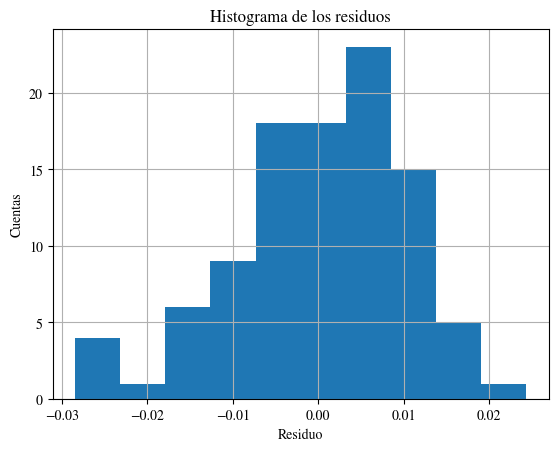

In [6]:
#Podemos hacer un histograma de los residuos
# y el histograma
plt.figure()
data_hist = plt.hist(residuo, bins='auto') # 'auto' es el máximo entre Freedman-Diaconis y Sturges. Quitándolo, el default es 10.
plt.title('Histograma de los residuos')
plt.xlabel("Residuo")
plt.ylabel("Cuentas")
plt.grid(True)
plt.show()

Ajustar por cuadrados mínimos es minimizar la distancia de los datos a lo esperado por el modelo propuesto, pesados por el error:

$$\chi^2 = \sum\left(\frac{y_\text{medido}-y_\text{modelo}}{\sigma_{y_i}}\right)^2$$

Si el modelo propuesto se corresponde a los datos medidos, al calcular el $\chi^2$ ("el estadístico") se obtienen resultados que andan cerca de $\nu$, que es la cantidad de grados de libertad del ajuste (#datos - #parámetros de ajuste). Si $\chi^2$ es mucho más grande que $\nu$, es indicativo de un ajuste pobre; si es algo más grande, que el ajuste no responde completamente a los datos, o que los errores fueron subestimados. Si, en cambio, $\chi^2<\nu$, es factible que el modelo esté sobreajustado: que se esté ajustando el ruido, o que los errores hayan sido sobreestimados.

Ahora consideremos que se miden los datos de nuevo: es esperable que $\chi^2$ vaya a dar levemente distinto, porque los datos van a ser levemente distintos, aunque seguramente dentro de las incertezas experimentales. Resulta que, si el modelo elegido es el correcto, los $\chi^2$ obtenibles en mediciones sucesivas siguen la distribución de probabilidades llamada $\chi^2_\nu$ [link a wikipedia](https://en.wikipedia.org/wiki/Chi-square_distribution):amada 
 [link a wikipedia]:

In [7]:
# Recursos necesarios para calcular el chi^2 y su p-valor:
puntos = len(x)
params = len(popt)
grados_libertad = puntos - params
y_modelo = f(x,popt[0],popt[1])

# calculo el chi^2 y su p-valor:
chi_cuadrado = np.sum(((y-y_modelo)/yerr)**2)
p_chi = stats.chi2.sf(chi_cuadrado, grados_libertad)
# interpretamos el resultado:
print('chi^2: ' + str(chi_cuadrado))
print('p-valor del chi^2: ' + str(p_chi))

if yerr[0]==0:
    print('No se declararon errores en la variable y.')
elif p_chi<0.05:
    print('Se rechaza la hipótesis de que el modelo ajuste a los datos.')
else:
    print('No se puede rechazar la hipótesis de que el modelo ajuste a los datos.')

chi^2: 102.4943311459727
p-valor del chi^2: 0.35803854707834293
No se puede rechazar la hipótesis de que el modelo ajuste a los datos.


**Extra: grafico de la distribución chi cuadrado y valor obtenido**

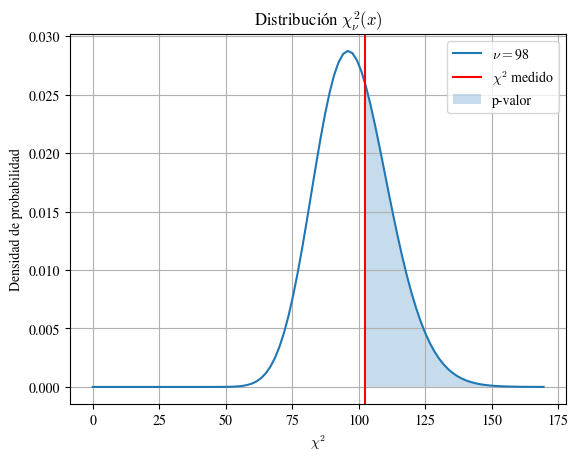

In [8]:
plt.figure()
plt.title(r'Distribución $\chi^2_\nu(x)$')
plt.xlabel(r'$\chi^{2}$')
plt.ylabel('Densidad de probabilidad')
# plt.xticks(range(100))
plt.grid(True)
x_chi2 = np.linspace(0, stats.chi2.ppf(0.99999, grados_libertad), 100)
plt.plot(x_chi2,stats.chi2.pdf(x_chi2, grados_libertad),label=r'$\nu=$'+str(grados_libertad))
plt.axvline(chi_cuadrado, color='r', label=r"$\chi^{2}$ medido")
x_chi2_pvalor = np.linspace(chi_cuadrado, stats.chi2.ppf(0.99999, grados_libertad), 100)

plt.fill_between(x_chi2_pvalor, np.zeros_like(x_chi2_pvalor),
                 stats.chi2.pdf(x_chi2_pvalor, grados_libertad), 
                 alpha=.25, label="p-valor")
plt.legend()  
plt.show()